### Let's fit a Fano resonance, this signal appears on superconducting resonators when photons interact with spins at low temperatures (from 4K to 10mK)

### https://en.wikipedia.org/wiki/Fano_resonance

In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import math
import scipy.optimize as sci
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from numpy import random

from qiskit.opflow import PauliSumOp
import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR, QSVR
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from IPython.display import clear_output
#from qiskit.opflow.gradients import Gradient
from qiskit_machine_learning.kernels import QuantumKernel
#from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, PauliFeatureMap, ZFeatureMap

import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

algorithm_globals.random_seed = 42
np.random.seed(100)
np.random.default_rng(100)

Generator(PCG64) at 0x1C98E446E58

In [2]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [3]:
fano_data.head()

,# signal_id,signal_original_x,signal_original_y,signal_fano_y,peak_xcoord,peak_ycoord,w,A,y0,xc,q,b_field
0,81.0,4.199235e+09,-0.000500,-0.000696,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
1,81.0,4.199248e+09,-0.000501,-0.000696,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
2,81.0,4.199261e+09,-0.000502,-0.000697,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
3,81.0,4.199274e+09,-0.000503,-0.000697,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
4,81.0,4.199287e+09,-0.000504,-0.000697,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024


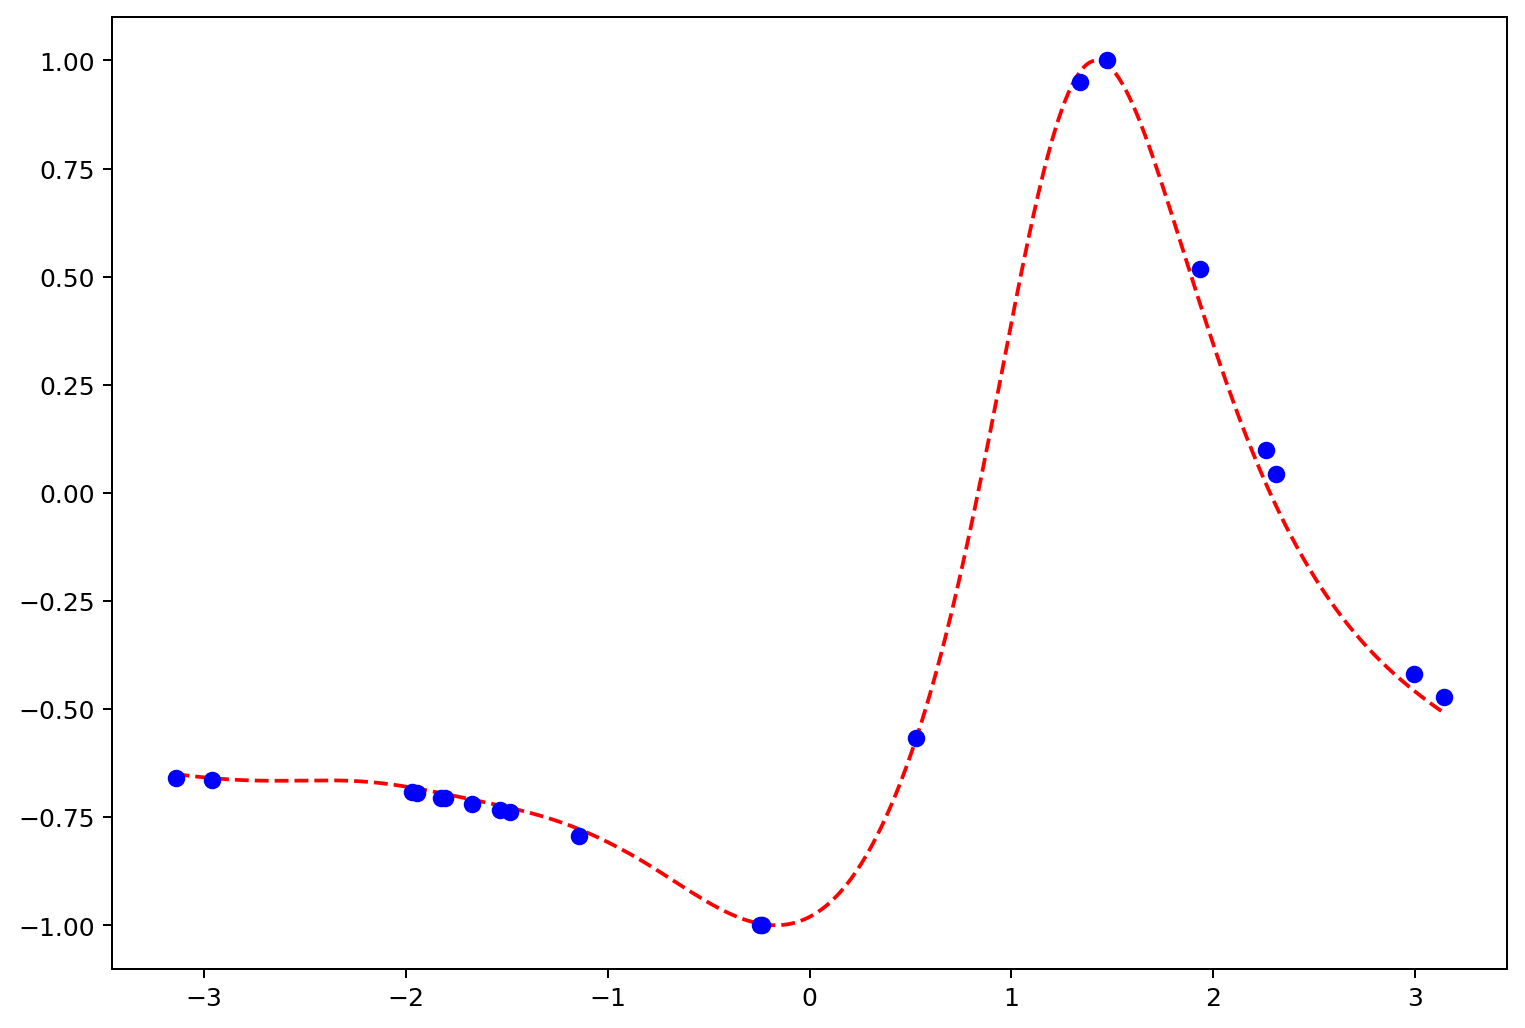

In [4]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

indices = sorted(np.random.choice(range(X_.shape[0]), 50, replace=False))
#X_ = X_[indices].reshape(-1,1)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values.reshape(-1,1)
#y_ = y_[indices].reshape(-1,1)

#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

# random indices for points selection
indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])

X = X_[indices].reshape(-1,1)

#X = (ub - lb) * np.random.choice(X_[:,0], size=num_samples).reshape(-1,1) + lb
#y = f(X[:, 0]) + eps * (2 * np.random.uniform(lb, ub, num_samples) + ub)

#X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
#y = f(X[:, 0])# + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

#X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
#y = f(X[:, 0]) + eps * (2* np.random.choice(X_[:,0], size=num_samples)  - 1)

#y = f(X[:, 0]) + (np.random.choice(y_[:,0], size=num_samples))
#y = f(X[:, 0]) + eps * (2 * X - 1)

#y = f(X[:, 0])

y = y_[indices].reshape(-1,1)

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))
    
X = scale(X)

y = scale(y, -1, 1)
y = y[:,0]

X_ = scale(X_)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

plt.plot(X_, y_, "r--")
plt.plot(X, y, "bo")
plt.show()

# Fitting with scipy.curve_fit

In [5]:
def fano_func(x, y0, A, xc, w, q):

    res = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)

    return res

def fano_errfunc(guess, x, y):

    y0 = guess[0]
    A = guess[1]
    xc = guess[2]
    w = guess[3]
    q = guess[4]
    
    res = y - fano_func(x, y0, A, xc, w, q)

    return res

def perform_fano_adjust(x, y, y0_guess, A_guess, xc_guess, w_guess, q_guess, lb, ub):

    guess = [y0_guess, A_guess, xc_guess, w_guess, q_guess]

    #return sci.least_squares(fano_errfunc, guess, args=(x,y), bounds=(lb, ub)) # works
    #return sci.leastsq(fano_errfunc, guess, args=(x,y), maxfev=100000)
    return sci.curve_fit(fano_func, x, y, guess, bounds=(lb, ub), maxfev=1000000)


In [6]:
A_adjust = 0.020
w_adjust = 11e4
q_adjust = 2.0
xc_param_adjust = fano_data["xc"].values[0]

low_bound = []
up_bound = []

x_sci = fano_data["signal_original_x"].values.reshape(-1,1)[:,0]
y_sci = fano_data["signal_original_y"].values.reshape(-1,1)[:,0] 
#y_sci = f(x_sci.reshape(-1,1))[:,0]

y0_adjust = -A_adjust*(-2*xc_param_adjust/w_adjust+q_adjust)**2/(1+(2*xc_param_adjust/w_adjust)**2)*1/(1+q_adjust**2)

fitparams, pcov = perform_fano_adjust(x_sci, y_sci, y0_adjust, A_adjust, xc_param_adjust, w_adjust, q_adjust, low_bound, up_bound)

fano_adjust_result = fano_func(x_sci, *fitparams)

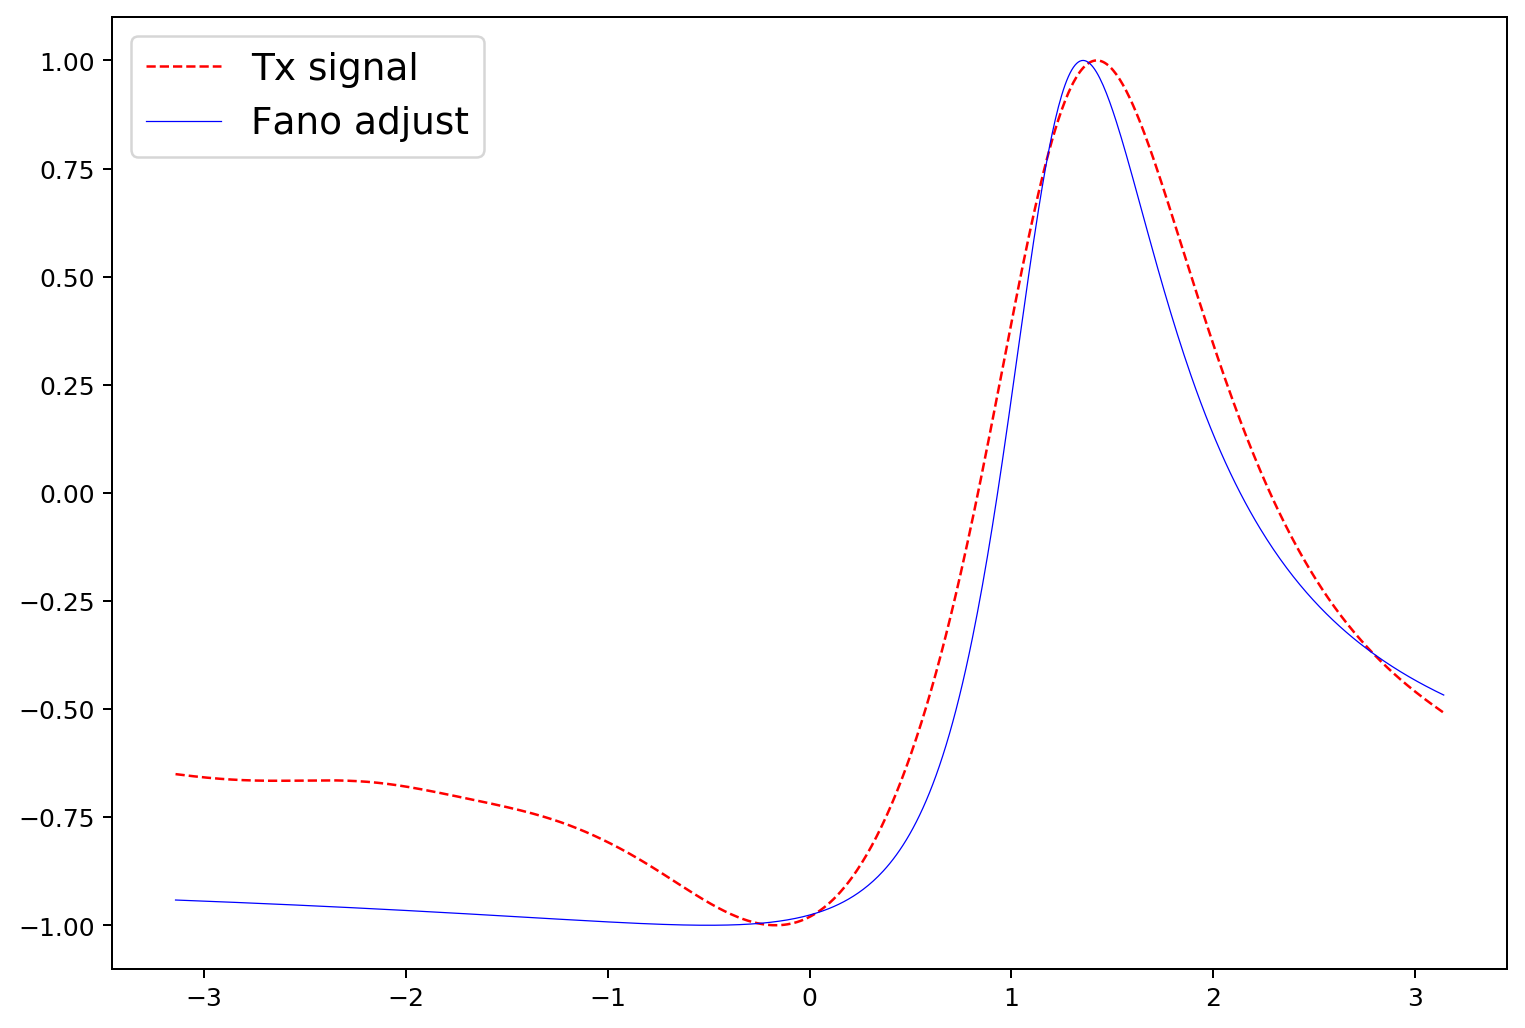

In [7]:
x_sci = scale(x_sci)
y_sci = scale(y_sci, -1, 1)

fano_adjust_result = scale(fano_adjust_result, -1, 1)

fano_adjust_result = scale(fano_adjust_result, lvalue = -1, rvalue = 1)
plt.figure(num = "Fano adjust single", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
        
plt.plot(x_sci, y_sci, 'r--',  label='Tx signal', linewidth = 1)
plt.plot(x_sci, fano_adjust_result, 'r-', color="blue", linewidth = 0.5, label = 'Fano adjust')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

# Classical Machine Learning

In [8]:
svr = GridSearchCV(
    SVR(kernel="rbf", gamma=0.1),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
)

kr = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)},
)

In [9]:
train_size = 100
t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print("")
print(f"Best SVR with params: {svr.best_params_} and R2 score: {svr.best_score_:.3f}")
print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("")
print(f"Best KRR with params: {kr.best_params_} and R2 score: {kr.best_score_:.3f}")
print("KRR complexity and bandwidth selected and model fitted in %.3f s" % kr_fit)

sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
y_svr = svr.predict(X)
svr_predict = time.time() - t0
print("")
print("SVR prediction for %d inputs in %.3f s" % (X.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s" % (X.shape[0], kr_predict))


Best SVR with params: {'C': 1.0, 'gamma': 0.01} and R2 score: -21.203
SVR complexity and bandwidth selected and model fitted in 0.091 s

Best KRR with params: {'alpha': 1.0, 'gamma': 0.1} and R2 score: -13.079
KRR complexity and bandwidth selected and model fitted in 0.111 s
Support vector ratio: 0.120

SVR prediction for 20 inputs in 0.000 s
KRR prediction for 20 inputs in 0.000 s


In [10]:
#model = SVR(kernel="rbf", gamma=9.0, C=9.0)
model = KernelRidge(kernel="rbf", gamma=1.0, alpha = 0.01)
model.fit(X, y)

KernelRidge(alpha=0.01, gamma=1.0, kernel='rbf')

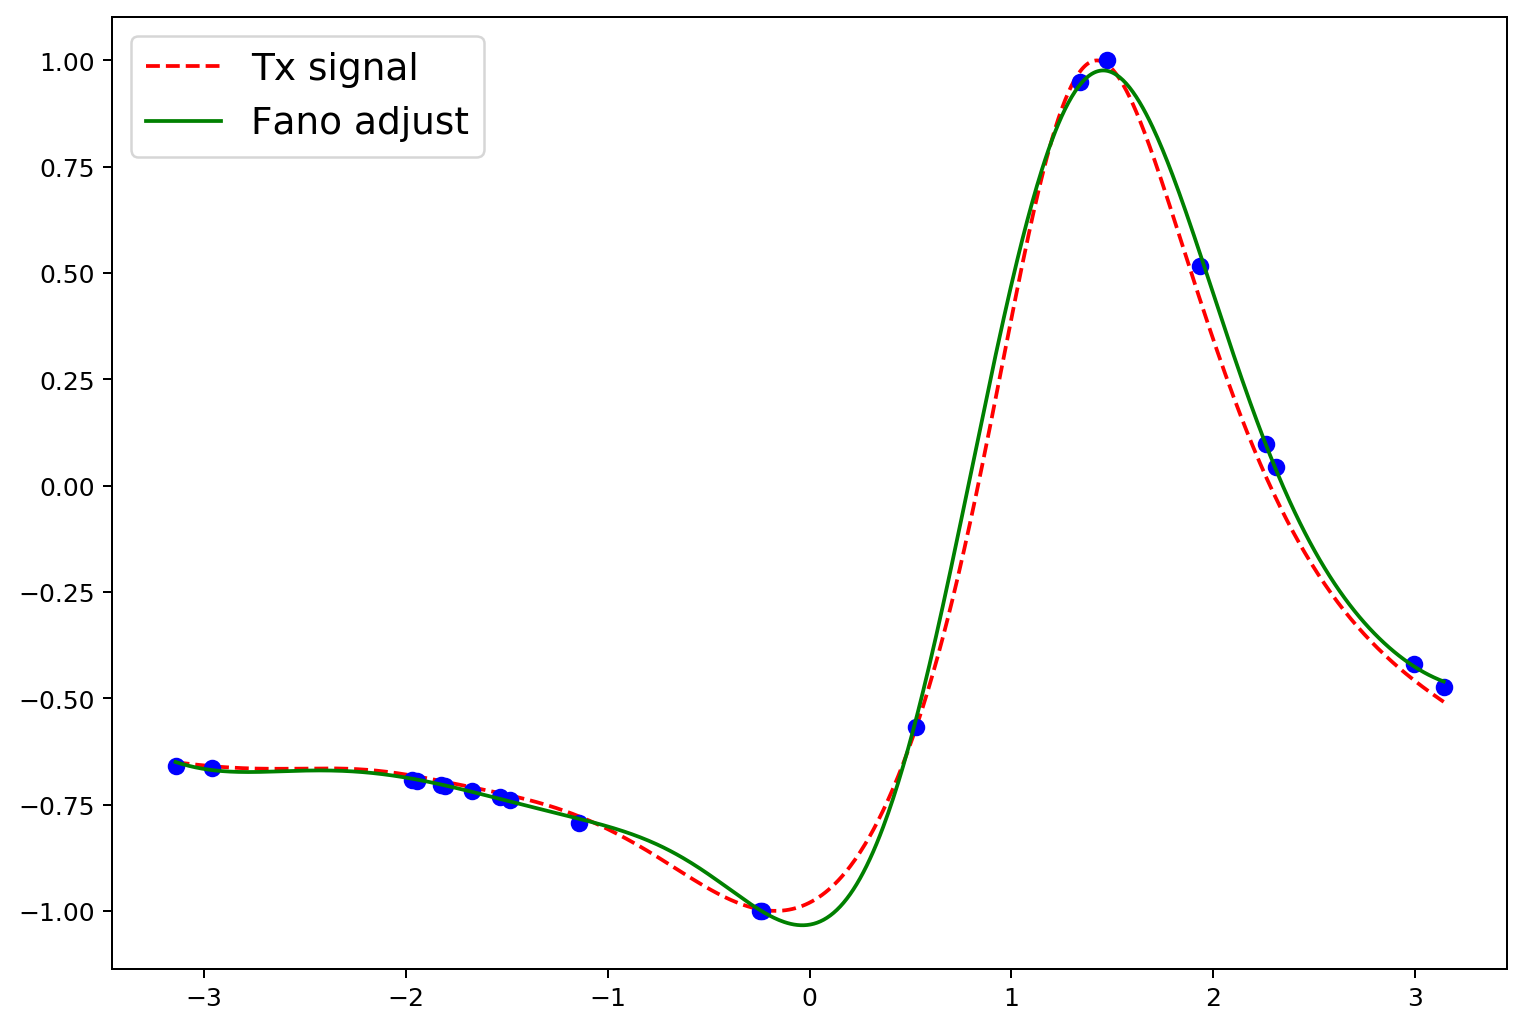

In [11]:
plt.figure(num = "Fano adjust ML", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_predict = model.predict(X_)
plt.plot(X_, y_predict, "g-", label = 'Fano adjust')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [12]:
model.score(X_, y_)

0.9937085669433054

# Quantum Machine Learning Regressors

## Quantum Neural Network Regressor

In [13]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [44]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

observable = PauliSumOp.from_list([("Z" * 1, 0.8)])

# construct QNN
regression_opflow_qnn = TwoLayerQNN(1, feature_map, ansatz, observable = observable, quantum_instance=quantum_instance)

In [45]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [46]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_opflow_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(),
    #optimizer=COBYLA(400),
    callback=callback_graph,
)

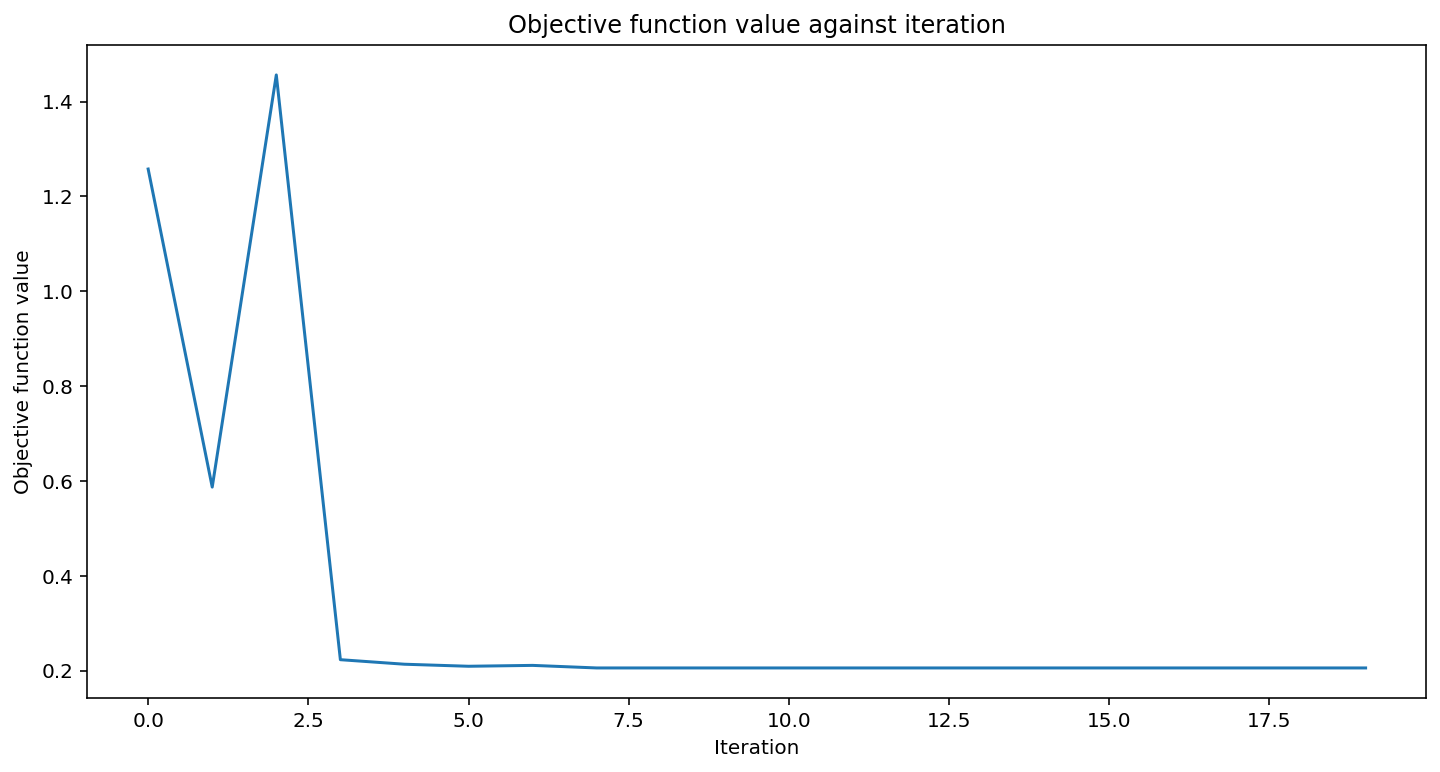

0.38613910915807503

In [47]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y.reshape(-1,1))

# return to default figsize
plt.rcParams['figure.figsize'] = [10, 7]

# score the result
regressor.score(X, y)

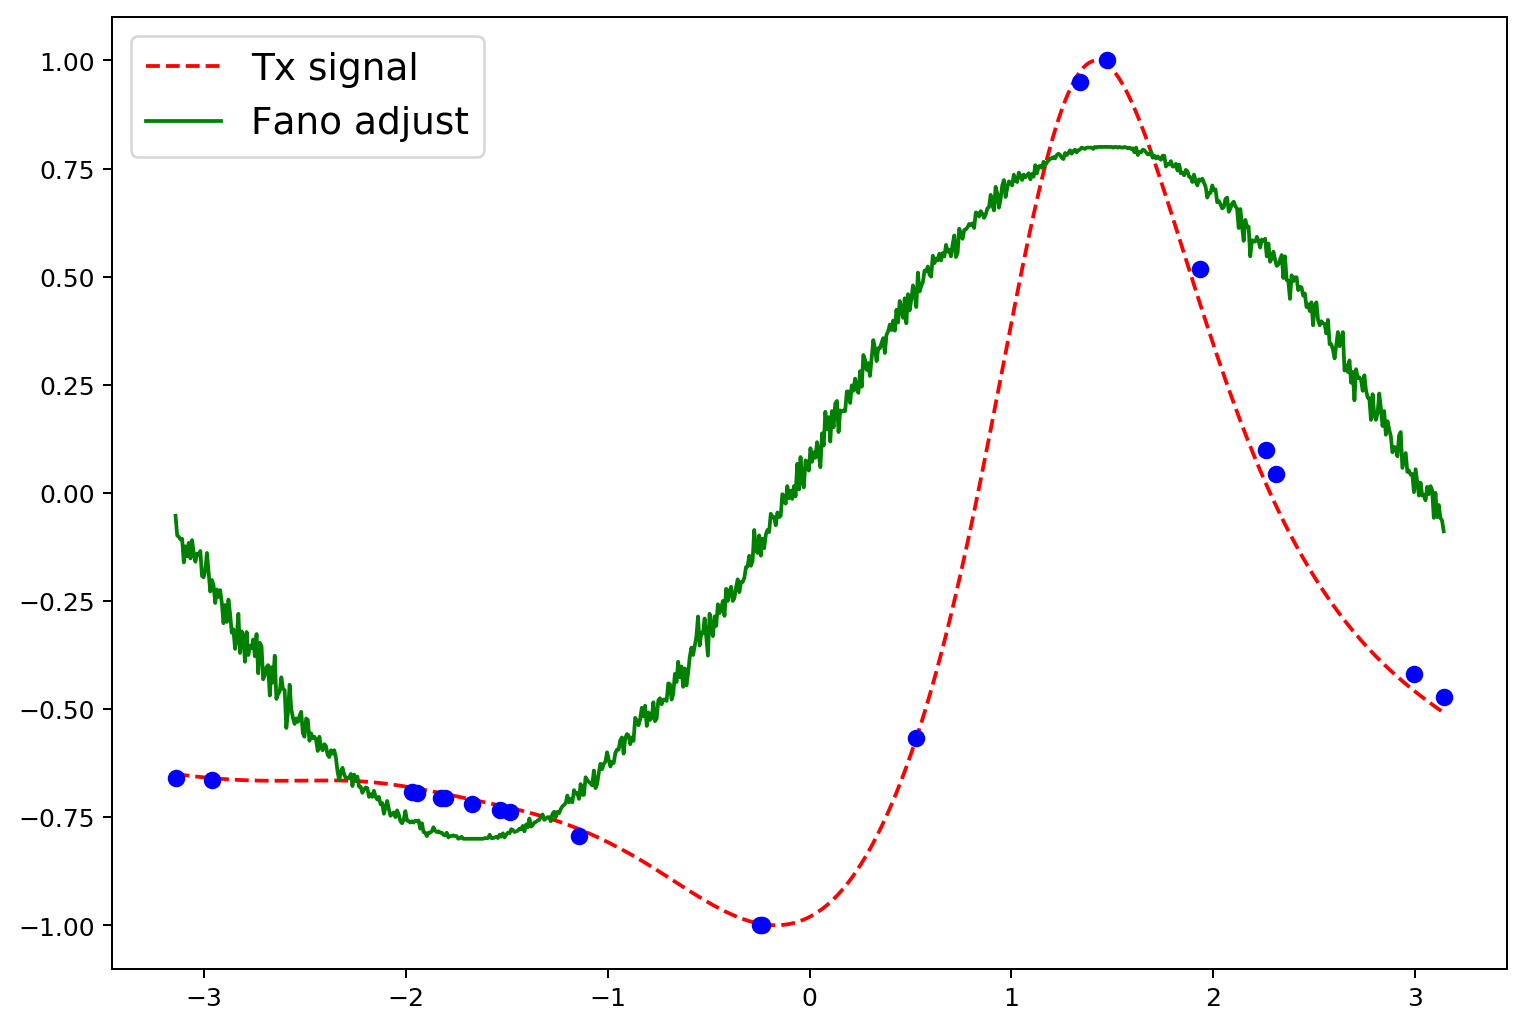

In [48]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_predict = regressor.predict(X_)
plt.plot(X_, y_predict[:,0], "g-", label = 'Fano adjust')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

## Variational Quantum Regressor

In [19]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

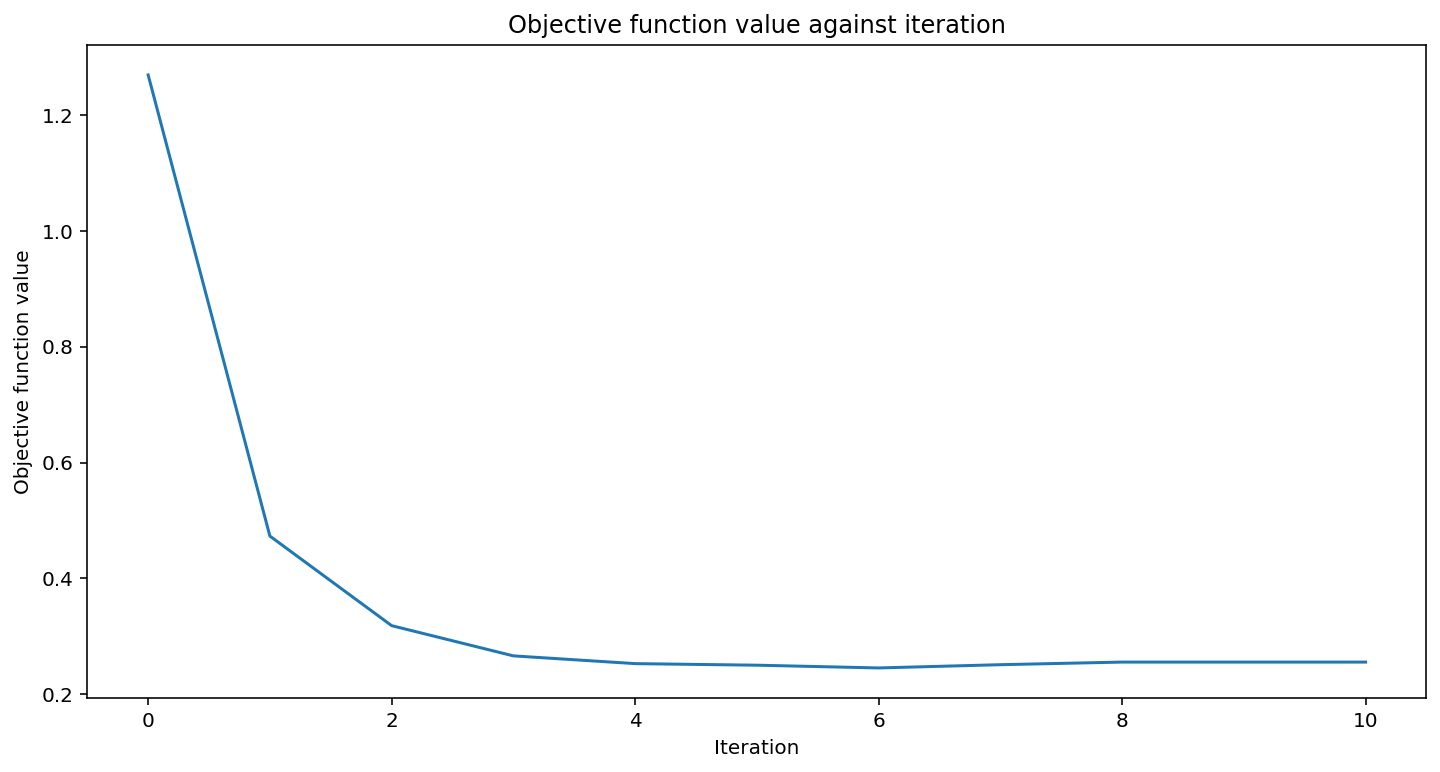

0.25747572642835637

In [20]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams['figure.figsize'] = [10, 7]

# score result
vqr.score(X, y)

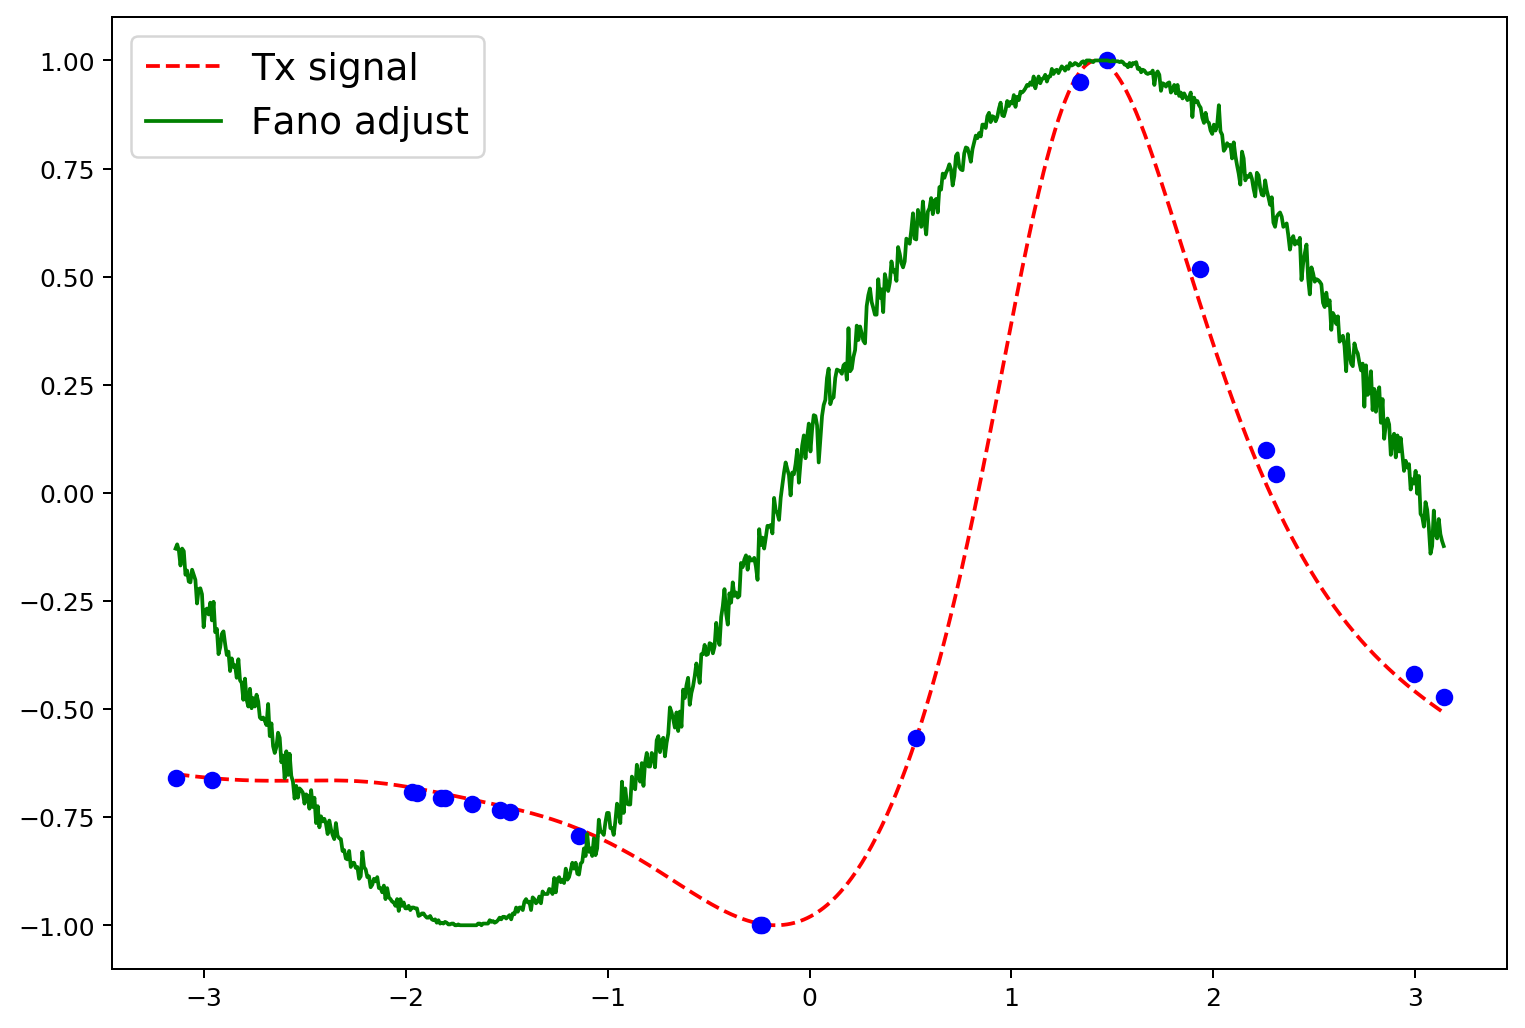

In [21]:
plt.figure(num = "Fano adjust QML 2", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_predict = vqr.predict(X_)
plt.plot(X_, y_predict, "g-", label = 'Fano adjust')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

## Quantum Support Vector Regressor

In [22]:
qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
#qkernel.evaluate(x_vec=X)

qsvr = QSVR(quantum_kernel=qkernel)
qsvr.fit(X, y)

QSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
     max_iter=-1,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000001C98F4C43C8>,
     shrinking=True, tol=0.001, verbose=False)

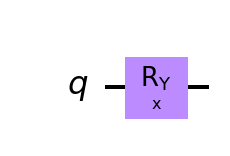

In [23]:
feature_map.draw('mpl')

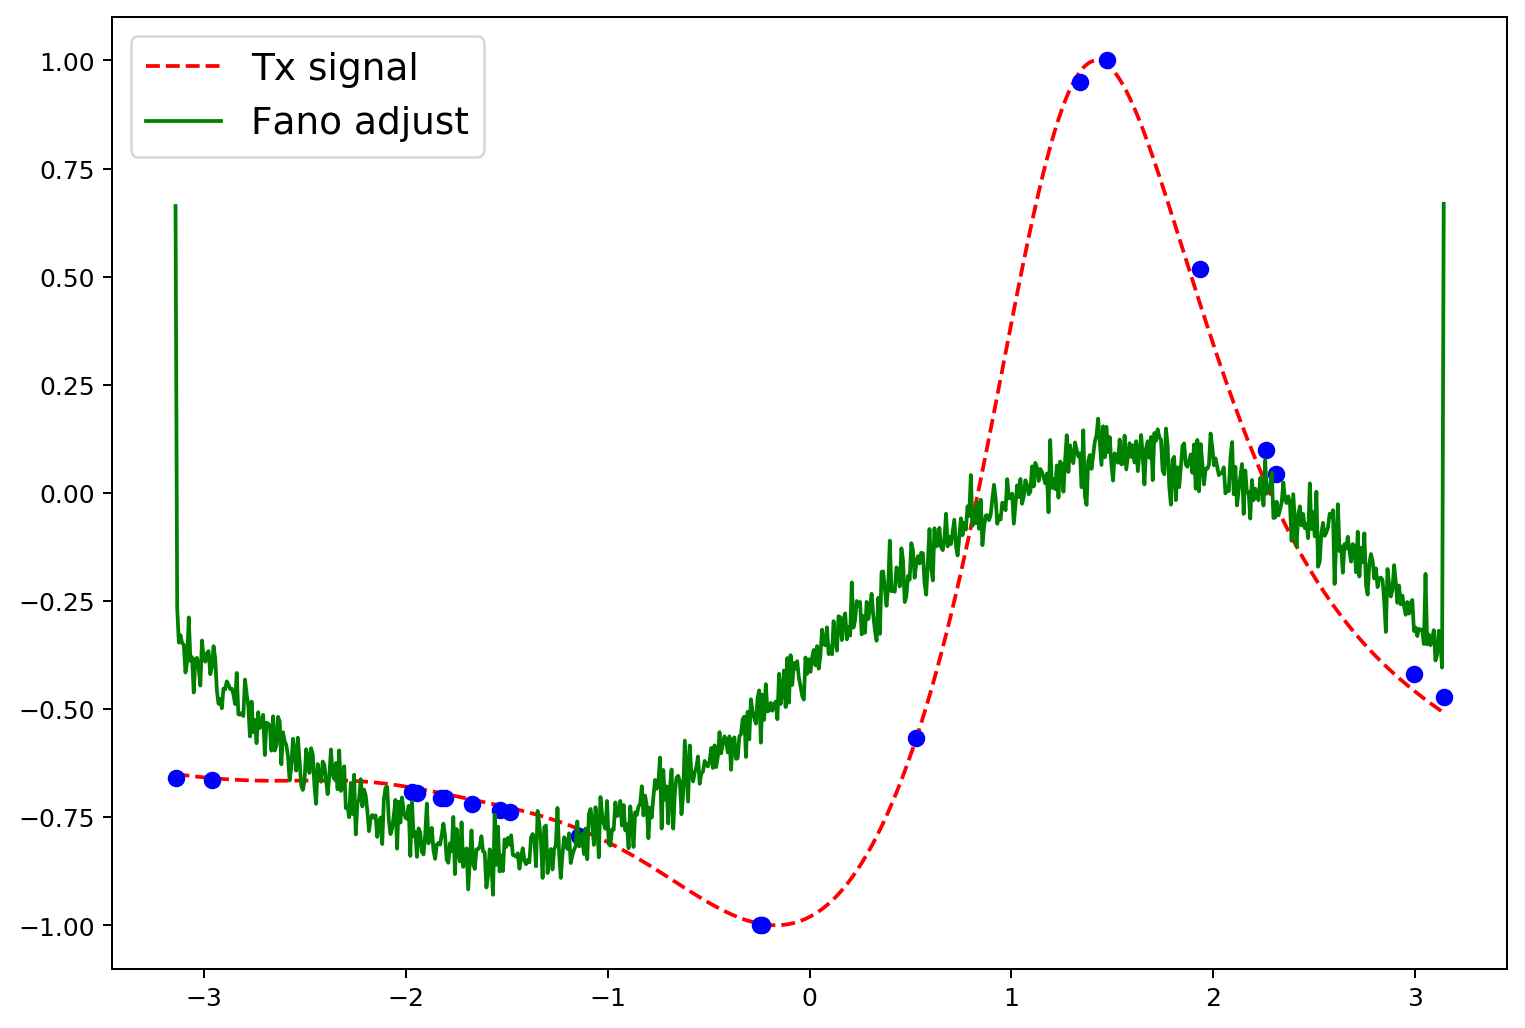

In [24]:
plt.figure(num = "Fano adjust QML 3", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_predict = qsvr.predict(X_)
plt.plot(X_, y_predict, "g-", label = 'Fano adjust')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [25]:
qsvr.score(X, y)

0.6223808455465426

# Custom Quantum Ridge regressor

In [33]:
class QuantumRidge:
    def __init__(self, gamma, quantum_instance, feature_map):
        self.q_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
        self.gamma = gamma

    def fit(self, X_train, y_train):
        self.X_train = X_train
        n_train = y_train.size
        I = np.eye(n_train)
        K_train = self.q_kernel.evaluate(x_vec=X_train)
        K_train = K_train + self.gamma * I
        self.alpha = np.linalg.solve(K_train, y_train)

    def predict(self,X_test):
        K_test = self.q_kernel.evaluate(self.X_train, X_test).T
        prediction = K_test @ self.alpha
        return prediction

In [34]:
qr_norm = QuantumRidge(1,quantum_instance,feature_map)
#qr_norm.gamma = -0.1

qr_norm.fit(X,y)
y_pred = qr_norm.predict(X_)

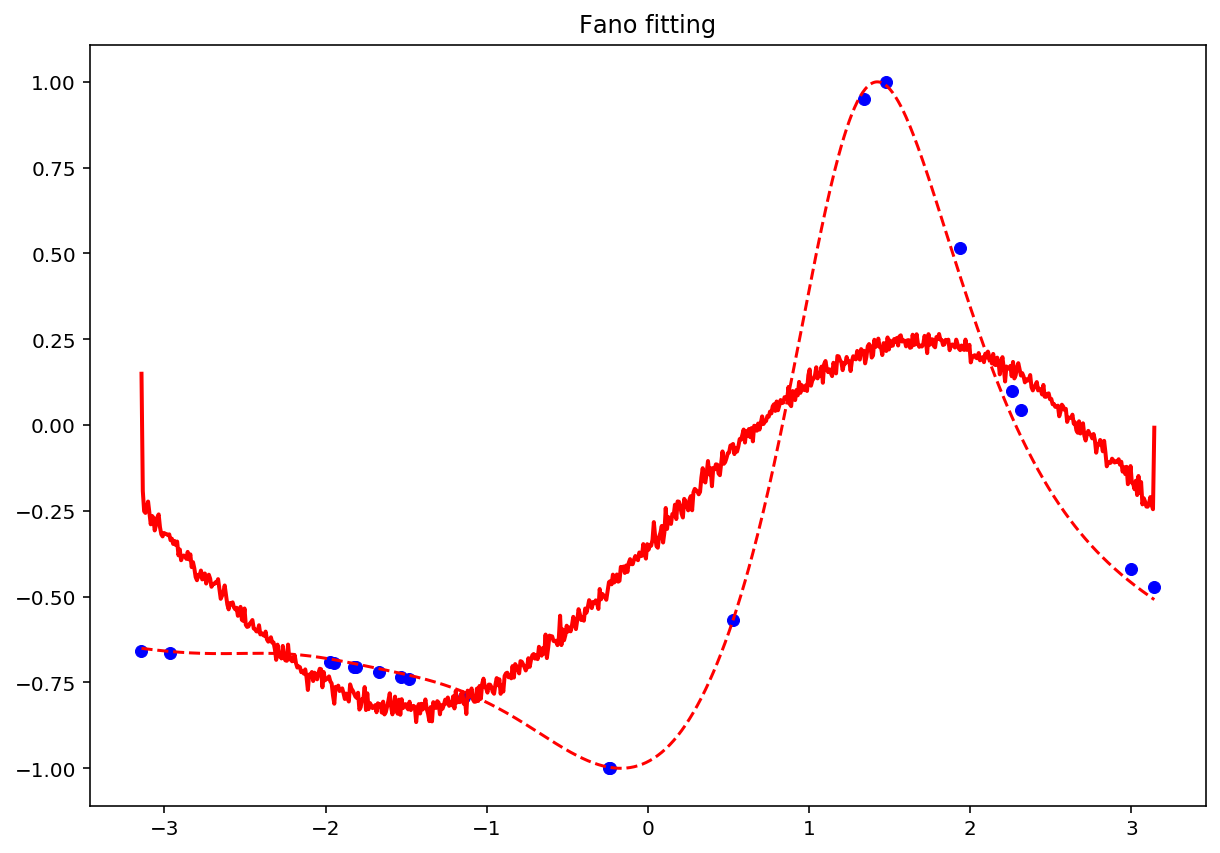

In [35]:
plt.title("Fano fitting")
plt.scatter(X, y,linewidth=0.5,c="b")
plt.plot(X_,y_pred,linewidth=2,c="r")
plt.plot(X_, y_, "r--", label = 'Tx signal')
plt.show()

## Quantum Classical Variational Algorithm Approach

In [29]:
quantum_kernel = KernelRidge(kernel=qkernel.evaluate)
quantum_kernel.fit(X, y)

KernelRidge(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000001C98F4C43C8>>)

In [30]:
score = quantum_kernel.score(X,y)
 
print('Kernel Ridge Regression Score: %.1f' % score)

Kernel Ridge Regression Score: 0.6


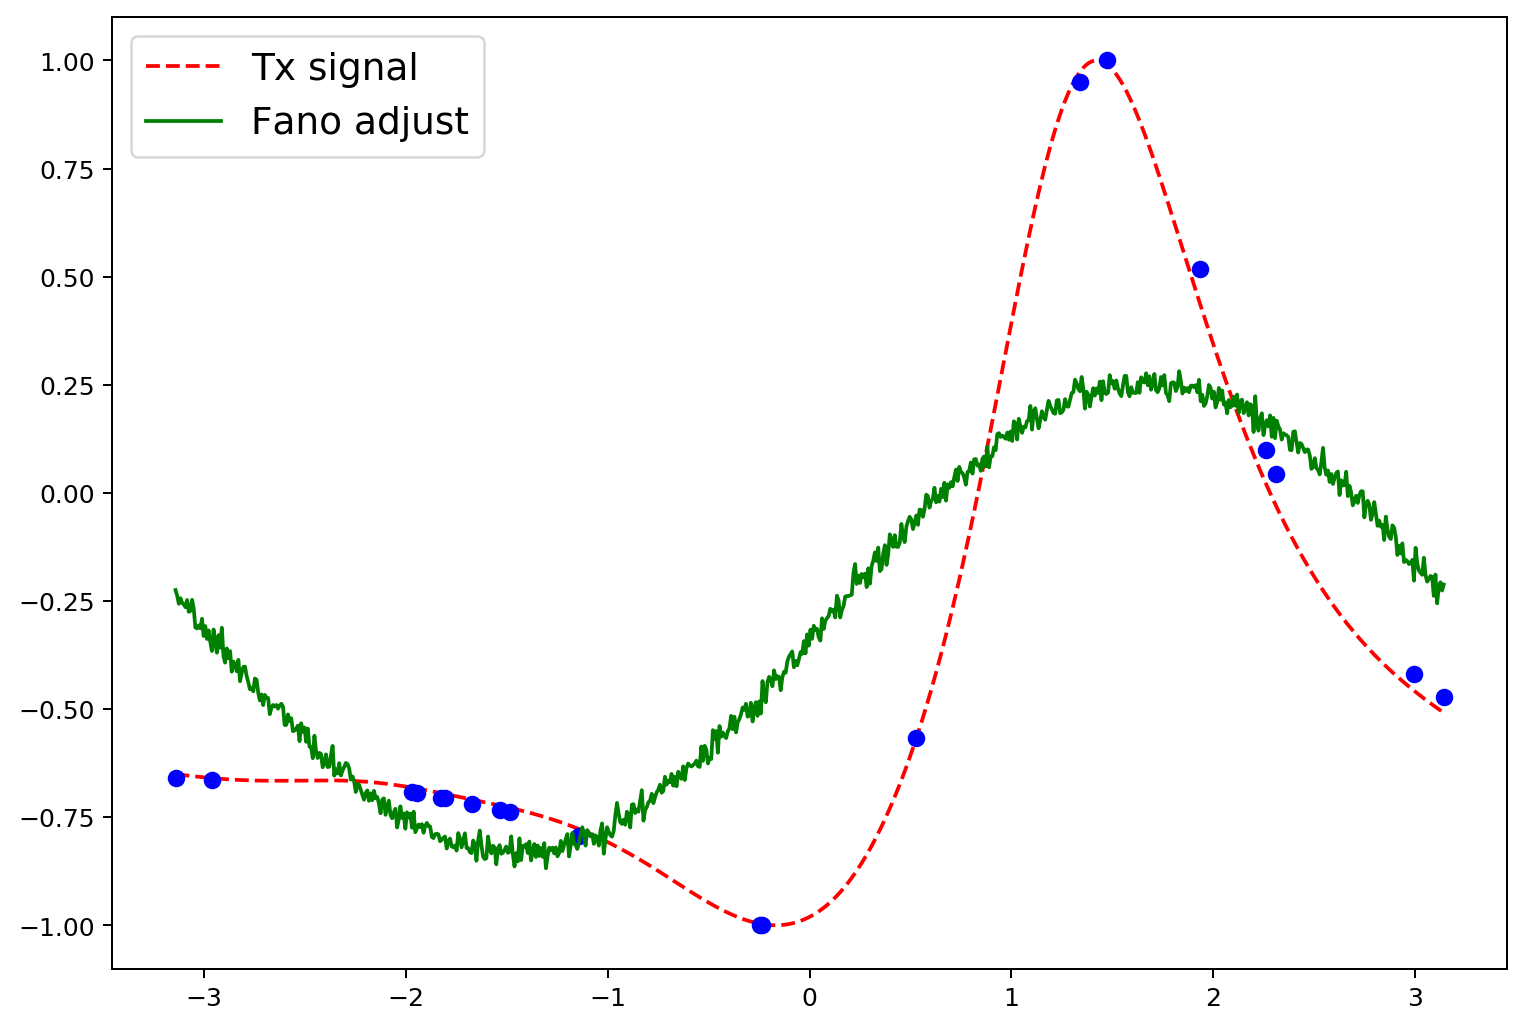

In [31]:
plt.figure(num = "Fano adjust QML 3", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_predict = quantum_kernel.predict(X_)
plt.plot(X_, y_predict, "g-", label = 'Fano adjust')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()